# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary classifier.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use a random forest regressor, as well as another classifier of your choice; either logistic regression, SVM, or KNN. 

- **Question**: Why would we want this to be a classification problem?
- **Answer**: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = 'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=0'

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup

In [3]:
r = requests.get(URL)

In [4]:
soup = BeautifulSoup(r.text,"html.parser")

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [5]:
#Retrieves salary, title, company and location
def salary (soup):
    salary = []
    for row in soup.findAll('td', {'class':'snip'}):
        try:
            salary.append(row.find('nobr').getText())
        except:
            salary.append('NA')
    return salary

def title (soup):
    title = []
    for row in soup.findAll('h2', {'class':'jobtitle'}):
        try:
            title.append(row.find('a').get('title'))
            
        except:
            title.append("NA")
    return title
        
def company(soup):
    company = []
    for row in soup.findAll('span', {'class':'company'}):
        try:
            company.append(row.getText().replace(' ','').replace('\n',''))
        except:
            company.append("NA")
    return company
        
def location(soup):
    location = []
    for row in soup.findAll('span', {'class':'location'}):
        try:
            location.append(row.getText())
        except:
            location.append("NA")
    return location

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [20]:
YOUR_CITY = 'Washington+DC'

In [32]:
#Scrapes up to 5000 results for each city 
import pandas as pd

max_results_per_city = 5000

results = pd.DataFrame()

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
    for start in range(0, max_results_per_city, 10):
        url = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=" + city + "&start="+ str(start)
        r = requests.get(url)        
        soup = BeautifulSoup(r.text,"html.parser")
        salary_df = pd.DataFrame(salary(soup), columns = ['Salary'])
        title_df= pd.DataFrame(title(soup), columns = ['Title'])
        company_df = pd.DataFrame(company(soup), columns = ['Company'])
        location_df = pd.DataFrame(location(soup), columns = ['Location'])
        aggregate = pd.concat([salary_df, title_df, company_df, location_df], axis = 1)
        results = results.append(aggregate)

In [33]:
results.shape

(119753, 4)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [38]:
#Remove resuls without a salary
results[results.Salary != 'NA']

,Salary,Title,Company,Location
6,"$80,000 - $120,000 a year",Data Scientist / Software Developer – Oil and Gas,AvispaTechnology,"Houston, TX"
3,"$135,000 a year",Affiliated Scientist I,DISYS,"Houston, TX 77027 (River Oaks area)"
10,"$70,000 - $130,000 a year",NaN,SelbyJennings,"Houston, TX"
4,"$160,000 a year",Science Consultant,OscarTechnology,"Houston, TX"
8,"$60,998 a year",IR Research/Systems Analyst,BaylorCollegeofMedicine,"Houston, TX"
9,"$105,000 - $115,000 a year","Process Development Scientist, III",Clearpoint,"Houston, TX"
5,"$54,590 a year",Quantitative Research Scientist - Options Stra...,BaylorCollegeofMedicine,"Houston, TX"
9,"$72,120 a year",MBA Consultant,BaylorCollegeofMedicine,"Houston, TX"
5,"$75,000 - $120,000 a year",Project Associate,SelbyJennings,"Houston, TX"
7,"$70,000 a year","Data Scientist, Big Data, Machine Learning",TexasA&MUniversity,"Houston, TX 77058 (Pasadena area)"


In [60]:
#No salary results were saved to a csv. The code pulled those results back in to allow me to work on at different times 
#from that point
import pandas as pd
results = pd.read_csv(r'C:\Users\An\Desktop\DSI-DC-2\projects\project-04\starter-code\resultsNoNA.csv', sep='\t')

In [61]:
results.drop_duplicates(inplace = True)

In [62]:
#Keep only data with yearly salary. Monthly and hourly wages are not needed
yearly_results = results[results['Salary'].str.contains('year')]

In [63]:
yearly_results = yearly_results[['Salary', 'Title', 'Company', 'Location']]

In [64]:
yearly_results

,Salary,Title,Company,Location
0,"$80,000 - $120,000 a year",Data Scientist / Software Developer – Oil and Gas,AvispaTechnology,"Houston, TX"
1,"$135,000 a year",Affiliated Scientist I,DISYS,"Houston, TX 77027 (River Oaks area)"
2,"$70,000 - $130,000 a year",NaN,SelbyJennings,"Houston, TX"
3,"$160,000 a year",Science Consultant,OscarTechnology,"Houston, TX"
4,"$60,998 a year",IR Research/Systems Analyst,BaylorCollegeofMedicine,"Houston, TX"
5,"$105,000 - $115,000 a year","Process Development Scientist, III",Clearpoint,"Houston, TX"
6,"$54,590 a year",Quantitative Research Scientist - Options Stra...,BaylorCollegeofMedicine,"Houston, TX"
7,"$72,120 a year",MBA Consultant,BaylorCollegeofMedicine,"Houston, TX"
8,"$75,000 - $120,000 a year",Project Associate,SelbyJennings,"Houston, TX"
9,"$70,000 a year","Data Scientist, Big Data, Machine Learning",TexasA&MUniversity,"Houston, TX 77058 (Pasadena area)"


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [67]:
#Salary conversion function finds long strings over 17 characters and averages the min and max of the salary range. 
#The Indeed salary data follows a pattern of "$X a year" or "X-Y a year"
def convert_salary(x):
    import re
    import pandas as pd
    first = float()
    second = float()
    if len(x)>17:  #Long strings represent a salary range, "X-Y a year" 
        num_list = re.findall('\d+', x)  #Gets the digits from the string and puts them into a list
        num_list = pd.to_numeric(num_list)
        first = num_list[0]*1000+num_list[1]  #Gets the first number and multiplies by 1000. num_list[0] is XX in XX,YYY 
        second = num_list[2]*1000+num_list[3] #Gets the third number and multiplies by 1000. num_list[2] is AA in AA,BBB 
        return (first+second)/2
    else:
        num_list = re.findall('\d+', x)
        num_list = pd.to_numeric(num_list)
        first = num_list[0]*1000+num_list[1]
        return first
     
#Tests the conversion    
print convert_salary('78,687 − 101,385 a year')    

90036


In [68]:
yearly_results.Salary = yearly_results.Salary.map(convert_salary) 

In [69]:
yearly_results

,Salary,Title,Company,Location
0,100000,Data Scientist / Software Developer – Oil and Gas,AvispaTechnology,"Houston, TX"
1,135000,Affiliated Scientist I,DISYS,"Houston, TX 77027 (River Oaks area)"
2,100000,NaN,SelbyJennings,"Houston, TX"
3,160000,Science Consultant,OscarTechnology,"Houston, TX"
4,60998,IR Research/Systems Analyst,BaylorCollegeofMedicine,"Houston, TX"
5,110000,"Process Development Scientist, III",Clearpoint,"Houston, TX"
6,54590,Quantitative Research Scientist - Options Stra...,BaylorCollegeofMedicine,"Houston, TX"
7,72120,MBA Consultant,BaylorCollegeofMedicine,"Houston, TX"
8,97500,Project Associate,SelbyJennings,"Houston, TX"
9,70000,"Data Scientist, Big Data, Machine Learning",TexasA&MUniversity,"Houston, TX 77058 (Pasadena area)"


### Save your results as a CSV

In [70]:
## Save data to a csv
yearly_results.to_csv(r'C:\Users\An\Desktop\DSI-DC-2\projects\project-04\starter-code\results_final.csv', sep='\t', encoding='utf-8')

## Predicting salaries using Random Forests + Another Classifier

#### Load in the the data of scraped salaries

In [212]:
##Pull the data from the csv
import pandas as pd
results_final = pd.read_csv('results_final.csv', sep='\t')

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [213]:
## Find the median salary
results_final.Salary.median()

100000.0

In [214]:
#Segment the data by high and low salaries
def categorize_sal(x):
    if (x <= 100000):
        return 'Low'
    else:
        return 'High'

results_final['salary_category'] = results_final.Salary.map(categorize_sal)

#### Thought experiment: What is the baseline accuracy for this model?

Baseline accuracy is 170/(165+170) = 50.7%

#### Create a Random Forest model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. 

In [215]:
#Convert locations into the same format of City, State
def location_truncate(x):
    import re
    try:
        return re.findall('.*[A-Z][A-Z]', x)[0]
    except:
        return x
    
results_final['Location'] = results_final['Location'].apply(location_truncate)

In [216]:
#There are still some outlier cities that can be consolidated
results_final.Location.value_counts(normalize=True)

New York, NY                  0.271642
Chicago, IL                   0.098507
Atlanta, GA                   0.056716
Washington, DC                0.050746
San Francisco, CA             0.044776
Los Angeles, CA               0.041791
Philadelphia, PA              0.035821
Houston, TX                   0.029851
Seattle, WA                   0.026866
Phoenix, AZ                   0.023881
Austin, TX                    0.020896
Fort George G Meade, MD       0.017910
Dallas, TX                    0.017910
Berkeley, CA                  0.017910
Pittsburgh, PA                0.017910
Arlington, VA                 0.014925
Portland, OR                  0.014925
Denver, CO                    0.011940
Miami, FL                     0.008955
Union, NJ                     0.008955
Rockville, MD                 0.008955
Newark, NJ                    0.008955
Bellevue, WA                  0.008955
Scottsdale, AZ                0.005970
Brisbane, CA                  0.005970
Fort Meade, MD           

In [258]:
results_final.Location.value_counts()

New York, NY                  91
Chicago, IL                   33
Atlanta, GA                   19
Washington, DC                17
San Francisco, CA             15
Los Angeles, CA               14
Philadelphia, PA              12
Houston, TX                   10
Seattle, WA                    9
Phoenix, AZ                    8
Austin, TX                     7
Fort George G Meade, MD        6
Dallas, TX                     6
Berkeley, CA                   6
Pittsburgh, PA                 6
Arlington, VA                  5
Portland, OR                   5
Denver, CO                     4
Miami, FL                      3
Union, NJ                      3
Rockville, MD                  3
Newark, NJ                     3
Bellevue, WA                   3
Scottsdale, AZ                 2
Brisbane, CA                   2
Fort Meade, MD                 2
San Francisco Bay Area, CA     2
Long Island City, NY           2
Gaithersburg, MD               2
Redwood City, CA               2
Evanston, 

In [218]:
## Create dummies for location and run a random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = pd.get_dummies(results_final['Location'], drop_first = True)
y = results_final['salary_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


rf = RandomForestClassifier(n_estimators = 30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print 'Accuracy', accuracy_score(y_test, y_pred)
print 'Confusion Matrix','\n',  confusion_matrix(y_test, y_pred)
print 'Classification Report','\n', classification_report(y_test, y_pred)

Accuracy 0.589285714286
Confusion Matrix 
[[61 24]
 [45 38]]
Classification Report 
             precision    recall  f1-score   support

       High       0.58      0.72      0.64        85
        Low       0.61      0.46      0.52        83

avg / total       0.59      0.59      0.58       168



#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Random Forest with these features. Do they add any value? 


In [219]:
## Create new title features
def senior(x):
    if 'SENIOR' in x.upper():
        return 1
    else:
        return 0
    
def manager(x):
    if 'MANAGER' in x.upper():
        return 1
    else:
        return 0
    
def director(x):
    if 'DIRECTOR' in x.upper():
        return 1
    else:
        return 0
    
def data_scientist(x):
    if 'DATA SCIENTIST' in x.upper():
        return 1
    else:
        return 0
    
def consultant(x):
    if 'CONSULTANT' in x.upper():
        return 1
    else:
        return 0

results_final['Title'] = results_final.Title.apply(str)    
results_final['senior_in_title'] = results_final.Title.map(senior)
results_final['manager_in_title'] = results_final.Title.map(manager)
results_final['director_in_title'] = results_final.Title.map(director)
results_final['data_scientist_in_title'] = results_final.Title.map(data_scientist)
results_final['consultant_in_title'] = results_final.Title.map(consultant)

In [220]:
#No high correlations
results_final.corr()

,Unnamed: 0,Salary,senior_in_title,manager_in_title,director_in_title,data_scientist_in_title,consultant_in_title
Unnamed: 0,1.000000,0.094770,-0.058265,0.004860,0.098523,-0.084955,-0.162586
Salary,0.094770,1.000000,0.063817,-0.004051,0.073727,0.004198,-0.023626
senior_in_title,-0.058265,0.063817,1.000000,-0.002892,-0.057005,0.131893,-0.035725
manager_in_title,0.004860,-0.004051,-0.002892,1.000000,-0.032321,-0.026203,-0.020255
director_in_title,0.098523,0.073727,-0.057005,-0.032321,1.000000,-0.070862,-0.019283
data_scientist_in_title,-0.084955,0.004198,0.131893,-0.026203,-0.070862,1.000000,-0.044409
consultant_in_title,-0.162586,-0.023626,-0.035725,-0.020255,-0.019283,-0.044409,1.000000


In [221]:
#Classifier based solely off of title features
X = results_final[['senior_in_title','manager_in_title','director_in_title','data_scientist_in_title','consultant_in_title']]
y = results_final['salary_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


rf = RandomForestClassifier(n_estimators = 30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print 'Accuracy', accuracy_score(y_test, y_pred)
print 'Confusion Matrix','\n',  confusion_matrix(y_test, y_pred)
print 'Classification Report','\n', classification_report(y_test, y_pred)

Accuracy 0.52380952381
Confusion Matrix 
[[24 61]
 [19 64]]
Classification Report 
             precision    recall  f1-score   support

       High       0.56      0.28      0.38        85
        Low       0.51      0.77      0.62        83

avg / total       0.54      0.52      0.49       168



In [222]:
#Location and title features combined

loc_dummies = pd.get_dummies(results_final['Location'], drop_first = True)
title_features = results_final[['senior_in_title','manager_in_title','director_in_title','data_scientist_in_title','consultant_in_title']]

X = pd.concat([loc_dummies, title_features], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


rf = RandomForestClassifier(n_estimators = 30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print 'Accuracy', accuracy_score(y_test, y_pred)
print 'Confusion Matrix','\n',  confusion_matrix(y_test, y_pred)
print 'Classification Report','\n', classification_report(y_test, y_pred)

Accuracy 0.577380952381
Confusion Matrix 
[[54 31]
 [40 43]]
Classification Report 
             precision    recall  f1-score   support

       High       0.57      0.64      0.60        85
        Low       0.58      0.52      0.55        83

avg / total       0.58      0.58      0.58       168



#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model. 

In [223]:
## Use cross-validation with fold of 3
from sklearn.cross_validation import cross_val_score

score = cross_val_score(rf, X, y, cv = 3)
print 'Mean score of ',score.mean(), 'with std of ', score.std()


Mean score of  0.543168168168 with std of  0.0309842617786


#### Random Forest Regressor

Let's try treating this as a regression problem. 

- Train a random forest regressor on the regression problem and predict your dependent.
- Evaluate the score with a 5-fold cross-validation
- Do a scatter plot of the predicted vs actual scores for each of the 5 folds, do they match?

In [224]:
#Uses location and first set of title features with Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

y = results_final['Salary']
rfr = RandomForestRegressor(random_state =0, n_estimators = 30)
score = cross_val_score(rfr, X, y, cv = 5, scoring = 'r2')
print 'Mean score is', score.mean(), 'and std is', score.std()  

Mean score is 0.401177503968 and std is 0.204874330015


The X data is highly varied and training off of smaller set accents the variance. Perhaps training off of smaller data

In [225]:
#Just location Regressor
rfr = RandomForestRegressor(random_state =0, n_estimators = 30)
score = cross_val_score(rfr, pd.get_dummies(results_final.Location, drop_first = True), y, cv = 5, scoring = 'r2')
print 'Mean score is', score.mean(), 'and std is', score.std() 

Mean score is -0.330894920939 and std is 0.284346616542


In [226]:
#Add more title features

def analyst(x):
    if 'ANALYST' in x.upper():
        return 1
    else:
        return 0
    
def staff(x):
    if 'STAFF' in x.upper():
        return 1
    else:
        return 0
    
def junior(x):
    if 'JUNIOR' in x.upper():
        return 1
    else:
        return 0
    
results_final['analyst_in_title'] = results_final.Title.map(analyst)
results_final['staff_in_title'] = results_final.Title.map(staff)
results_final['junior_in_title'] = results_final.Title.map(junior)

In [227]:
title_features = results_final[['senior_in_title','manager_in_title','director_in_title','consultant_in_title', 'analyst_in_title','data_scientist_in_title', 'staff_in_title', 'junior_in_title']]

In [228]:
#Random Forest Classifier with added title columns
X = pd.concat([loc_dummies, title_features], axis = 1)
y = results_final.salary_category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

rf = RandomForestClassifier(n_estimators = 30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print 'Accuracy', accuracy_score(y_test, y_pred)
print 'Confusion Matrix','\n',  confusion_matrix(y_test, y_pred)
print 'Classification Report','\n', classification_report(y_test, y_pred)

Accuracy 0.577380952381
Confusion Matrix 
[[51 34]
 [37 46]]
Classification Report 
             precision    recall  f1-score   support

       High       0.58      0.60      0.59        85
        Low       0.57      0.55      0.56        83

avg / total       0.58      0.58      0.58       168



In [229]:
#K Nearest Neighbors with location and title features
from sklearn.neighbors import KNeighborsClassifier

X = pd.concat([loc_dummies, title_features], axis = 1)
y = results_final.salary_category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
y_pred = kn.predict(X_test)
print 'Accuracy', accuracy_score(y_test, y_pred)
print 'Confusion Matrix','\n',  confusion_matrix(y_test, y_pred)
print 'Classification Report','\n', classification_report(y_test, y_pred)

Accuracy 0.607142857143
Confusion Matrix 
[[38 47]
 [19 64]]
Classification Report 
             precision    recall  f1-score   support

       High       0.67      0.45      0.54        85
        Low       0.58      0.77      0.66        83

avg / total       0.62      0.61      0.60       168



In [230]:
#Random Forest Regressor with added title columns

y = results_final['Salary']
rfr = RandomForestRegressor()

score = cross_val_score(rfr, X, y, cv = 5, scoring = 'r2')
print 'Mean score is', score.mean(), 'and std is', score.std() 
print score

Mean score is -0.251846492871 and std is 0.255892101434
[-0.26832198 -0.72337631 -0.17499599 -0.13100954  0.03847136]


In [231]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

y = results_final['Salary']
lr = LogisticRegression()

score = cross_val_score(lr, X, y, cv = 5, scoring = 'r2')
print 'Mean score is', score.mean(), 'and std is', score.std() 
print score

Mean score is -0.376948016646 and std is 0.391832652896
[-0.69919391 -0.37778512 -0.12256864 -0.88883428  0.20364187]


In [232]:
#Linear Regression
from sklearn.linear_model import LinearRegression

y = results_final['Salary']
lr = LinearRegression()

score = cross_val_score(lr, X, y, cv = 5, scoring = 'r2')
print 'Mean score is', score.mean(), 'and std is', score.std() 
print score

Mean score is -7.70196408723e+26 and std is 1.24926361475e+27
[ -1.25715819e+26  -5.39376672e+24  -6.40447623e+24  -4.67757095e+26
  -3.24571089e+27]


In [233]:
#Support Vector Machines
from sklearn import svm

clf = svm.SVC()
score = cross_val_score(clf, X, y, cv = 5, scoring = 'r2')
print 'Mean score is', score.mean(), 'and std is', score.std() 

Mean score is -0.748910359854 and std is 0.258019589825


In [234]:
#K nearest neighbors regressor
from sklearn import neighbors

clf = neighbors.KNeighborsRegressor()
score = cross_val_score(clf, X, y, cv = 5, scoring = 'r2')
print 'Mean score is', score.mean(), 'and std is', score.std() 

Mean score is -0.551076316427 and std is 0.274491920001


In [261]:
#Title features proportion analysis
title_features.senior_in_title.value_counts()/len(title_features)

0    0.904478
1    0.095522
Name: senior_in_title, dtype: float64

In [236]:
title_features.manager_in_title.value_counts()

0    324
1     11
Name: manager_in_title, dtype: int64

In [256]:
title_features.director_in_title.value_counts()/len(title_features)

0    0.970149
1    0.029851
Name: director_in_title, dtype: float64

In [260]:
title_features.data_scientist_in_title.value_counts()/len(title_features)

0    0.859701
1    0.140299
Name: data_scientist_in_title, dtype: float64

In [257]:
title_features.staff_in_title.value_counts()/len(title_features)

0    0.997015
1    0.002985
Name: staff_in_title, dtype: float64

In [259]:
title_features.analyst_in_title.value_counts()/len(title_features)

0    0.835821
1    0.164179
Name: analyst_in_title, dtype: float64

In [241]:
title_features.junior_in_title.value_counts()

0    335
Name: junior_in_title, dtype: int64

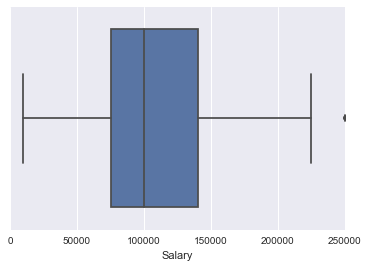

In [255]:
#Salary boxplot
import seaborn as sns
%matplotlib inline
sns.boxplot(results_final.Salary)

In [243]:
#Find random 100 entries and predict salaries
subset = X.iloc[1:101]

In [244]:
rfr = RandomForestRegressor()

rfr.fit_transform(X,y)
rfr.feature_importances_
feature_importance = pd.DataFrame(rfr.feature_importances_).transpose()

C:\Anaconda2\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [250]:
#Use Random Forest Regressor to predict characteristics of high salary posts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

y = results_final['Salary']
rfreg = RandomForestRegressor(n_estimators = 30)
rfreg.fit_transform(X_test,y_test)
predictions = pd.DataFrame(rfreg.predict(subset), columns = ['predictions'])

C:\Anaconda2\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [251]:
subset = X.iloc[1:101]
subset_final = pd.concat([subset, predictions], axis = 1)
subset_final.sort(columns = ['predictions'])

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,"Arlington, VA","Atlanta, GA","Aurora, CO","Austin, TX","Bala-Cynwyd, PA","Bellevue, WA","Berkeley, CA","Boulder, CO","Brisbane, CA","Brooklyn, NY",...,"Woodland Hills, CA",senior_in_title,manager_in_title,director_in_title,consultant_in_title,analyst_in_title,data_scientist_in_title,staff_in_title,junior_in_title,predictions
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62954.933333
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62954.933333
67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69574.900000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75933.766667
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,81765.155000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,83677.333333
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83677.333333
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83677.333333
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,83677.333333
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83677.333333


In [252]:
#Rows 81, 87, 85 have high predicted salaries
print subset_final.iloc[81,]

Arlington, VA                      0.000000
Atlanta, GA                        0.000000
Aurora, CO                         0.000000
Austin, TX                         0.000000
Bala-Cynwyd, PA                    0.000000
Bellevue, WA                       0.000000
Berkeley, CA                       0.000000
Boulder, CO                        0.000000
Brisbane, CA                       0.000000
Brooklyn, NY                       0.000000
Camden, NJ                         0.000000
Chantilly, VA                      0.000000
Chicago, IL                        1.000000
Conshohocken, PA                   0.000000
Dallas, TX                         0.000000
Dallas-Fort Worth, TX              0.000000
Deerfield, IL                      0.000000
Denver, CO                         0.000000
Duluth, GA                         0.000000
Evanston, IL                       0.000000
Fairfax, VA                        0.000000
Fort George G Meade, MD            0.000000
Fort Meade, MD                  